In [467]:
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "courier"
})

In [372]:
#put helper functions/calculations here!

def con(x):
    """Convert to float if possible"""
    try:
        return float(x)
    except:
        return None

def adjust_typing(data):
    data = data.convert_dtypes()
    data["Plx"] = data["Plx"].apply(con)
    data["e_Plx"] = data["e_Plx"].apply(con)
    data["B-V"] = data["B-V"].apply(con)
    data["Vmag"] = data["Vmag"].apply(con)
    data["Hpmag"] = data["Hpmag"].apply(con)
    data["_Glon"] = data["_Glon"].apply(con)
    return data

#parallax is given in milliarcseconds (mas). Following is an ordered list (same order as columns) of units:
#deg|deg|deg|deg|deg|deg|deg|deg|d|s| | | | |mag| | |deg|deg| |mas|mas/yr|mas/yr|mas|mas|mas|mas/yr|mas/yr| | | | | | | | | | |%| |mag|mag|mag|mag| |mag|mag| |mag|mag| | |mag|mag|mag| | |mag|mag|d| | | | | | | | | | | |deg|arcsec|arcsec|mag|mag| | | | | | | |mag| | | | |deg|deg
def add_dist_cols(data):
    """Adds columns related to distance, i.e. distance, standard distance error both negative and positive
        Since the standard error on the parallax does not give the same standard error for distance for both the + and -, we take both.
    """
    mas_to_pc = lambda x : 1/(np.tan(x/1000))
    data["Dist"] = abs(mas_to_pc(data["Plx"])) #convert mas to parsecs
    data["e_Dist_pos"] = mas_to_pc(data["Plx"]-data["e_Plx"]) - data["Dist"]
    data["e_Dist_neg"] = mas_to_pc(data["Plx"]+data["e_Plx"]) - data["Dist"]
    return data

def add_color_by_bv(data):
    data["Temp"] = 4600*(1/(0.92*data["B-V"]+1.7)+1/(0.92*data["B-V"]+0.62))
    return data
def add_mag(data):
    absmag_calc = lambda m, d : m-5*np.log10(d/10)
    data["absmag"] = absmag_calc(data["Hpmag"],data["Dist"])
    return data
#get all stars that are within 50pc (include stars where Dist-|e_Dist_neg| < 50, i.e. where the standard error makes it possible for the star to be within 50 pc)
def get_close_stars(data, dist, ρ):
    """Takes the data, a distance (in parsecs), and ρ (a percent error in distance), and returns a subset of the initial dataframe."""
    return data[(data["Dist"]+data["e_Dist_neg"] < dist) ][abs(data["e_Dist_neg"]/data["Dist"])<ρ]#[["HIP","Dist", "e_Dist_neg"]].sort_values("Dist", ascending = False)


#----APPLY ABOVE TO DATA-----
def run_all_preproc(data,get_close = True):
    data = adjust_typing(data)
    data = add_dist_cols(data)
    data = add_color_by_bv(data)
    data = add_mag(data)
    if get_close:
        data = get_close_stars(data, 50, 0.05)
    return data

In [261]:
data = pd.read_csv("Vizier/hip_full_formatted2.csv", sep=",", low_memory=False)
data

,_Glon,_Glat,_RAJ2000,_DEJ2000,_RAB1950,_DEB1950,_Elon2000,_Elat2000,_time,_etime,...,BD,CoD,CPD,(V-I)red,SpType,r_SpType,HIPep,Erratum,_RA.icrs,_DE.icrs
0,111.3597,-36.417,2.5542817,25.5267532,1.9084505,25.2485924,13.0113022,22.2950371,,0,...,B+24 7,,,0.42,F0III,X,HIPep,Erratum,2.55428171,25.526753
1,117.8018,-2.4347,2.5587584,60.0260469,1.8993345,59.7479435,36.181116,51.8039073,,0,...,B+59 4,,,1.23,G8III,X,HIPep,Erratum,2.5587584,60.026047
2,116.328,-11.4583,2.5680176,50.8848982,1.9129509,50.6066901,27.9612575,44.4761435,,0,...,B+50 14,,,1.08,K0,S,HIPep,Erratum,2.56801765,50.884898
3,116.5543,-10.1061,2.5685944,52.2551367,1.9137442,51.9770508,29.0524755,45.6089037,,0,...,B+51 12,,,-0.03,B9,S,HIPep,Erratum,2.56859443,52.255137
4,307.7633,-45.9035,2.5746672,-70.8368948,1.9654422,-71.115109,312.1564164,-60.7514104,,0,...,,,P-71 2,0.48,F2/F3V,1,HIPep,Erratum,2.5746672,-70.836895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118213,305.5981,-38.6129,2.5334041,-78.300717,1.9452866,-78.5786775,297.9814094,-64.4204886,,0,...,,,P-78 4,1.33,K3III,1,HIPep,Erratum,2.53340406,-78.300717
118214,320.0866,-66.5871,2.5389894,-49.1433742,1.909107,-49.4212892,337.2332878,-44.8670259,,0,...,,C-49 20,P-49 15,0.56,F5V,2,HIPep,Erratum,2.53898941,-49.143374
118215,355.806,-79.1764,2.5423143,-33.2810479,1.9084617,-33.5587074,347.5585568,-31.2126153,,0,...,,C-33 26,P-33 10,0.83,G8V,3,HIPep,Erratum,2.54231429,-33.281048
118216,67.8416,-78.1572,2.5433657,-19.9835787,1.9063664,-20.2616779,354.0603912,-19.2772135,,0,...,B-20 9,,,0.60,F7V,4,HIPep,Erratum,2.5433657,-19.983579


In [373]:
good_stuff = run_all_preproc(data.copy(deep=True))
data = run_all_preproc(data,False)

<ipython-input-372-48b6709b3f00>:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return data[(data["Dist"]+data["e_Dist_neg"] < dist) ][abs(data["e_Dist_neg"]/data["Dist"])<ρ]#[["HIP","Dist", "e_Dist_neg"]].sort_values("Dist", ascending = False)


In [213]:
good_stuff

,_Glon,_Glat,_RAJ2000,_DEJ2000,_RAB1950,_DEB1950,_Elon2000,_Elat2000,_time,_etime,...,SpType,r_SpType,HIPep,Erratum,_RA.icrs,_DE.icrs,Dist,e_Dist_pos,e_Dist_neg,Temp
75,82.2291,-75.0646,2.8160718,-15.4679774,2.179996,-15.7424089,356.2766277,-15.2794553,,0,...,F5V,4,HIPep,Erratum,2.81607181,-15.467977,18.871659,0.279052,-0.271059,6448.441919
84,112.7888,-31.6319,2.8434915,30.449575,2.1922705,30.1709904,15.6260988,26.6122458,,0,...,K0V,X,HIPep,Erratum,2.84349154,30.449575,34.061766,1.140034,-1.068567,5420.152135
100,313.2897,-58.8474,2.8991422,-57.472549,2.274755,-57.749824,329.9694737,-51.6632046,,0,...,K1V,1,HIPep,Erratum,2.89914223,-57.472549,36.407452,1.505638,-1.390700,5020.665377
115,347.1573,-78.3386,2.9333693,-35.1331196,2.2988017,-35.4128739,346.8699635,-32.9999548,,0,...,F3/F5V,3,HIPep,Erratum,2.93336928,-35.13312,21.794965,0.318759,-0.309718,6580.881646
139,112.231,-34.9531,3.0167662,27.0989536,2.3650203,26.8220369,14.1536636,23.5346266,,0,...,K0,S,HIPep,Erratum,3.01676621,27.098954,25.707203,0.833614,-0.782916,4637.228591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118071,108.5536,-44.244,2.1136653,17.4242998,1.4716207,17.1469363,9.0225413,15.1138691,,0,...,M0,S,HIPep,Erratum,2.11366527,17.4243,21.895389,0.962863,-0.885173,3854.680056
118083,113.4434,-25.4553,2.1705757,36.6271251,1.5252334,36.3506461,18.2987533,32.3631432,,0,...,F8IV,S,HIPep,Erratum,2.1705757,36.627125,33.036839,0.771362,-0.736979,6370.803054
118129,117.5269,-3.2772,2.2945211,59.1497796,1.6238581,58.874119,35.1166472,51.2149733,,0,...,F2III-IV,X,HIPep,Erratum,2.29452113,59.14978,16.677310,0.157788,-0.154868,6988.564782
118142,108.8699,-44.1846,2.3310181,17.5339216,1.6872154,17.2575215,9.2649998,15.1284086,,0,...,G2III,X,HIPep,Erratum,2.33101814,17.533922,51.860793,2.216332,-2.041873,5800.437593


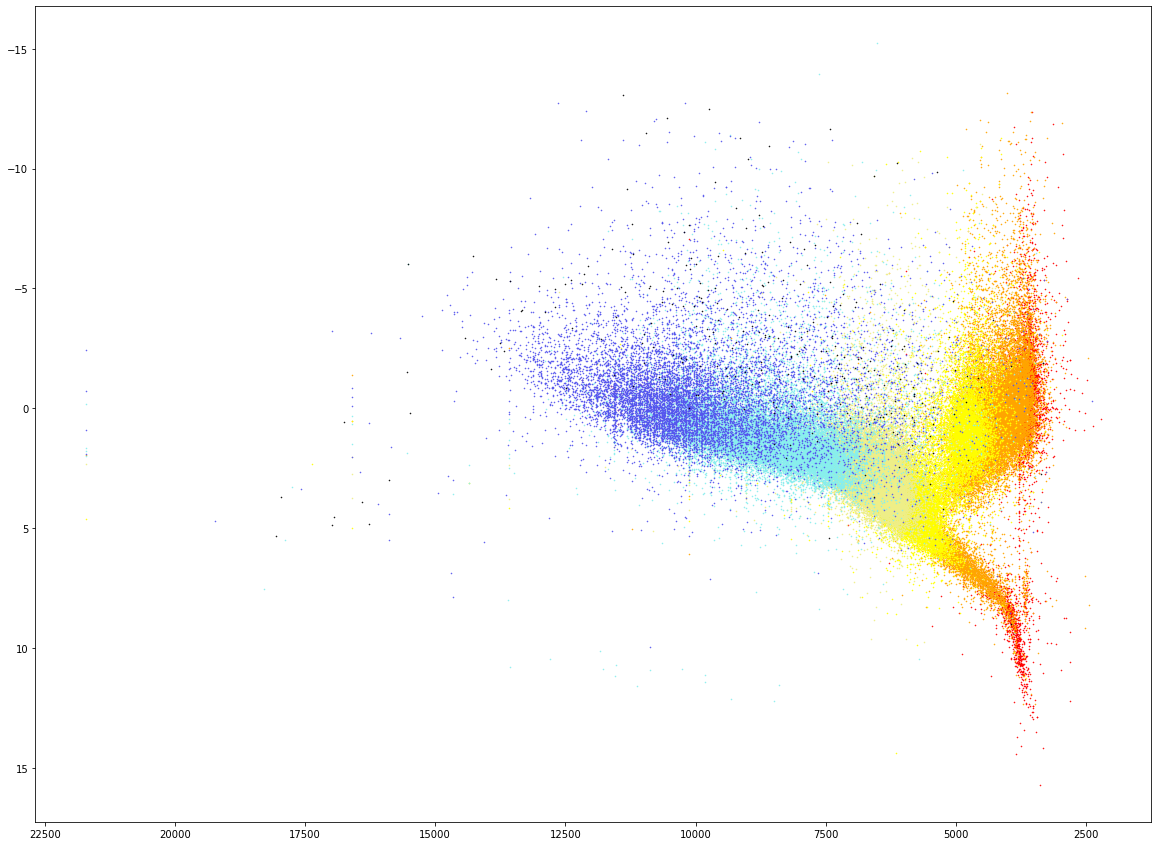

In [455]:


data_of_spec = lambda data, type_ : data[data["SpType"].str.contains(type_)]
scatter_spect = lambda data, type_, color : plt.scatter(data_of_spec(data,type_)["Temp"],data_of_spec(data,type_)["absmag"],s=.3,color = color)
#hertzprung russel diagram
#TODO: add color gradient across, and maybe do some group and text tags to show the different classes (white dwarves, main sequence, etc)
plt.figure(figsize=(20,15))
#plt.xlim(100,max(temps)*1.05)
scatter_spect(data, "M", "red")
scatter_spect(data, "K", "orange")
scatter_spect(data, "G", "yellow")
scatter_spect(data, "F", "#EEEE88")
scatter_spect(data, "A", "#88EEEE")
scatter_spect(data, "B", "#5555EE")
scatter_spect(data, "O", "black")

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

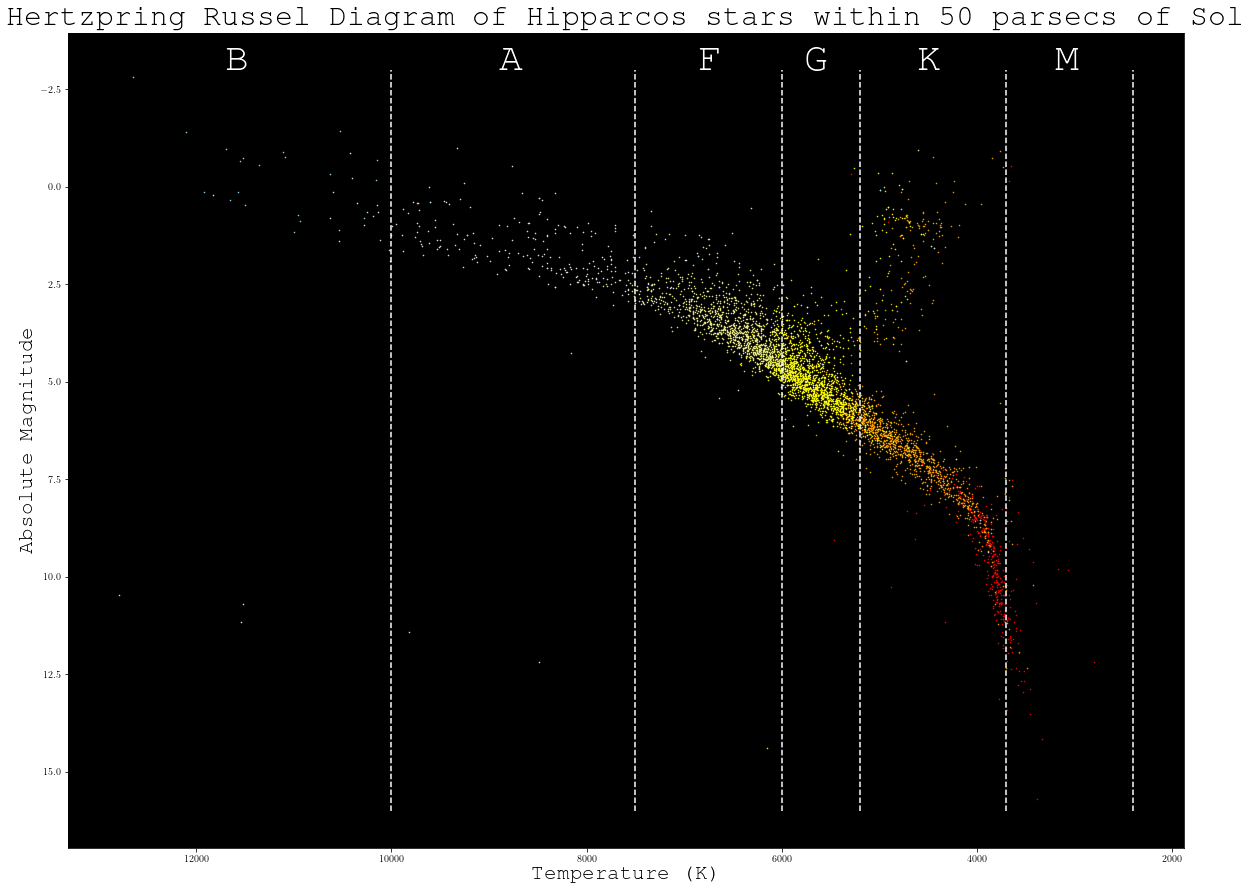

In [480]:
#hertzprung russel diagram
#TODO: add color gradient across, and maybe do some group and text tags to show the different classes (white dwarves, main sequence, etc)
vert = lambda x,y0,y1 : ax.plot([x,x],[y0,y1], '--w') 
fig,ax = plt.subplots(1,1, figsize=(20,15))
#plt.xlim(100,max(temps)*1.05)

vert(2400,16,-3)
ax.text(3200,-3, "M", fontsize=40, color = "white" )
vert(3700,16,-3)
ax.text(4600,-3, "K", fontsize=40, color = "white" )
vert(5200,16,-3)
ax.text(5750,-3, "G", fontsize=40, color = "white" )
vert(6000,16,-3)
ax.text(6850,-3, "F", fontsize=40, color = "white" )
vert(7500,16,-3)
ax.text(8900,-3, "A", fontsize=40, color = "white" )
vert(10000,16,-3)
ax.text(11700,-3, "B", fontsize=40, color = "white" )
#vert(30000,16,-3)


scatter_spect(good_stuff, "M", "red")
scatter_spect(good_stuff, "K", "orange")
scatter_spect(good_stuff, "G", "yellow")
scatter_spect(good_stuff, "F", "#EEEE88")
scatter_spect(good_stuff, "A", "#EEEEEE")
scatter_spect(good_stuff, "B", "#99DDFF")
scatter_spect(good_stuff, "O", "black")

ax.set_title("Hertzpring Russel Diagram of Hipparcos stars within 50 parsecs of Sol",fontsize = 30)
ax.set_xlabel("Temperature (K)", fontsize = 21)
ax.set_ylabel("Absolute Magnitude", rotation = 90, fontsize = 21)
ax.set_facecolor('black')
fig.set_facecolor('white')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.savefig("hr-diagram.png")
plt.show()

In [472]:
ax.savefig("hr-diagram.png")

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

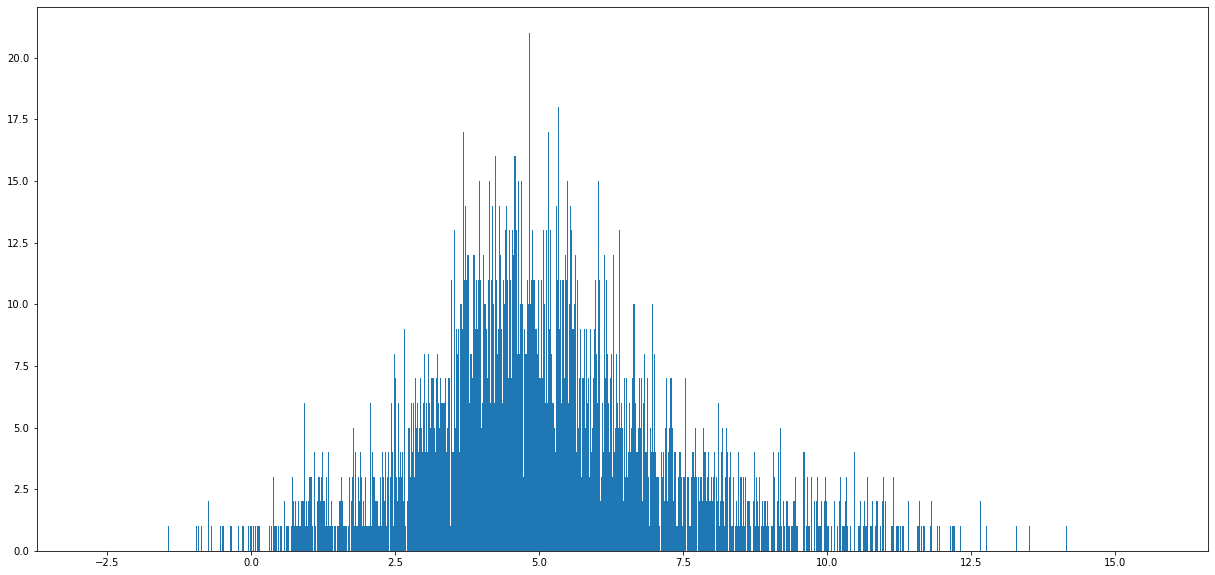

In [281]:
plt.figure(figsize=(21,10))
plt.hist(good_stuff["absmag"], bins=np.arange(min(good_stuff["absmag"]),max(good_stuff["absmag"]),.01))
plt.show()

In [270]:
data.iloc[0]["Hpmag"]-5*np.log10(data.iloc[0]["Dist"]/10)

1.969173931308827

In [269]:
5*np.log10(data.iloc[0]["Dist"])

12.02802606869117

In [165]:
data[data["HIP"] == 64289]["Dist"]+data[data["HIP"] == 64289]["e_Dist_neg"]

63397    42.408821
dtype: float64

In [133]:
temp = (1/(3.93))*1000
(1/(3.93+1.13))*1000-temp

-56.824467710627715

In [132]:
(1/(3.93-1.13))*1000 - temp

102.6899309342057

<ipython-input-452-314b6681664a>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.scatter(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["_Glon"]*2*np.pi/180, data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Dist"], s=.1, c=temp2rgb(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Temp"]))


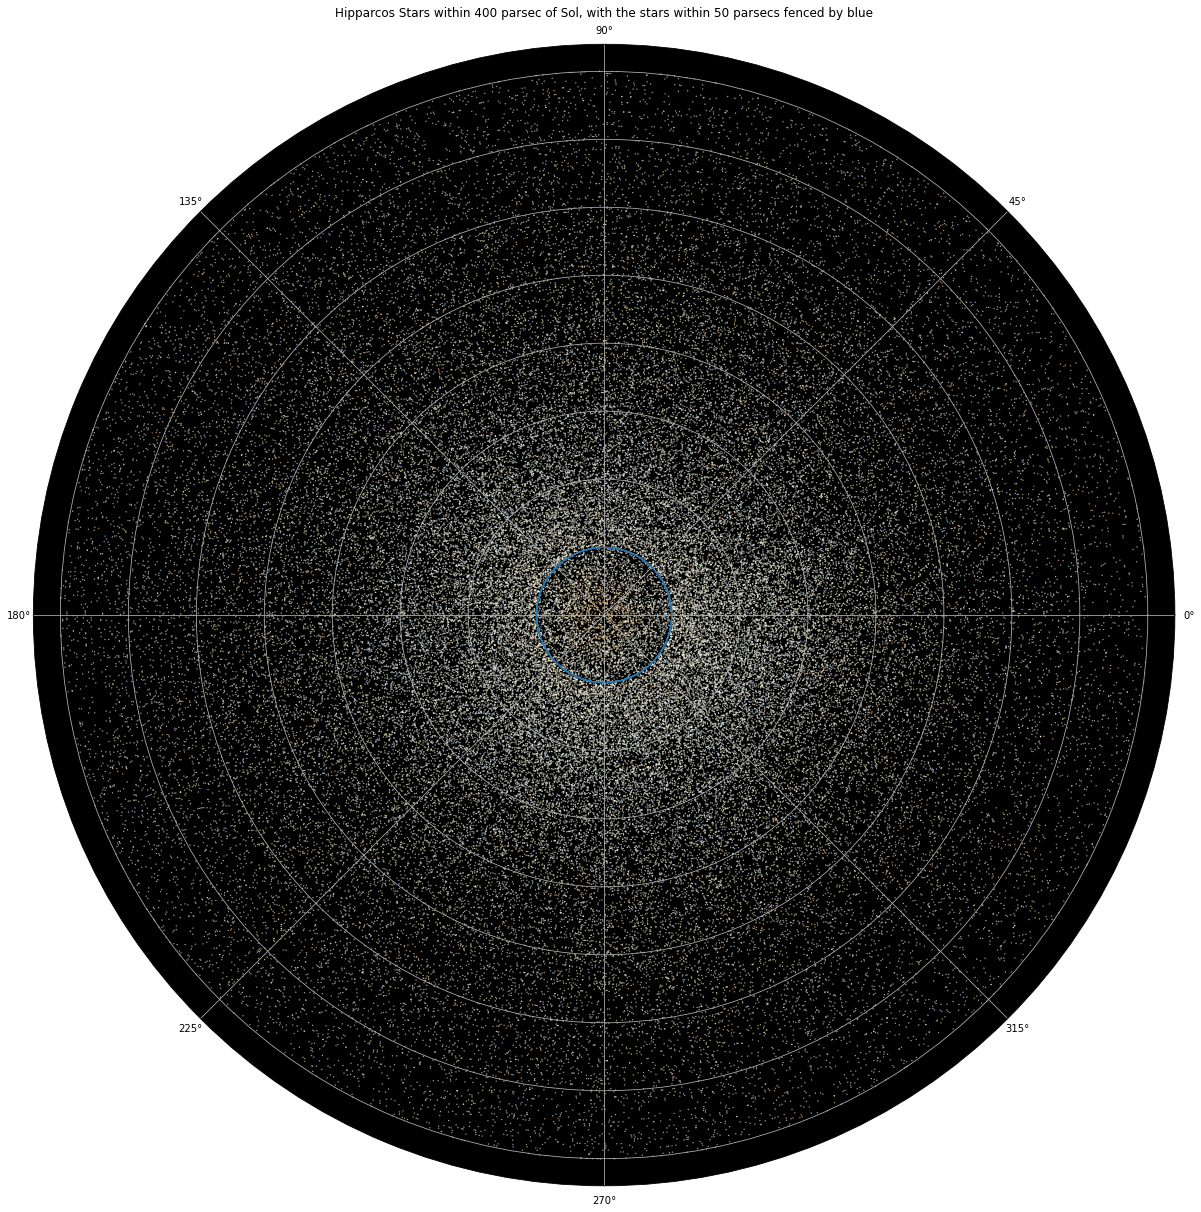

In [452]:
fig, ax = plt.subplots(1,1, figsize=(21,21),subplot_kw={'projection': 'polar'})

r = np.ones(1000)*50
theta = np.linspace(0,2 * np.pi * 50,1000)

data_max = 400
data_min = 51

ax.scatter(good_stuff.sort_values("_Glon")["_Glon"]*2*np.pi/180, good_stuff.sort_values("_Glon")["Dist"], s=.1, c=temp2rgb(good_stuff.sort_values("_Glon")["Temp"]))
ax.scatter(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["_Glon"]*2*np.pi/180, data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Dist"], s=.1, c=temp2rgb(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Temp"]))
ax.plot(theta, r, lw=0.1)
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Hipparcos Stars within 400 parsec of Sol, with the stars within 50 parsecs fenced by blue", va='bottom')
ax.set_facecolor('black')
plt.show()

In [434]:
redco = [ 1.62098281e-82, -5.03110845e-77, 6.66758278e-72, -4.71441850e-67, 1.66429493e-62, -1.50701672e-59, -2.42533006e-53, 8.42586475e-49, 7.94816523e-45, -1.68655179e-39, 7.25404556e-35, -1.85559350e-30, 3.23793430e-26, -4.00670131e-22, 3.53445102e-18, -2.19200432e-14, 9.27939743e-11, -2.56131914e-07,  4.29917840e-04, -3.88866019e-01, 3.97307766e+02]
greenco = [ 1.21775217e-82, -3.79265302e-77, 5.04300808e-72, -3.57741292e-67, 1.26763387e-62, -1.28724846e-59, -1.84618419e-53, 6.43113038e-49, 6.05135293e-45, -1.28642374e-39, 5.52273817e-35, -1.40682723e-30, 2.43659251e-26, -2.97762151e-22, 2.57295370e-18, -1.54137817e-14, 6.14141996e-11, -1.50922703e-07,  1.90667190e-04, -1.23973583e-02,-1.33464366e+01]
blueco = [ 2.17374683e-82, -6.82574350e-77, 9.17262316e-72, -6.60390151e-67, 2.40324203e-62, -5.77694976e-59, -3.42234361e-53, 1.26662864e-48, 8.75794575e-45, -2.45089758e-39, 1.10698770e-34, -2.95752654e-30, 5.41656027e-26, -7.10396545e-22, 6.74083578e-18, -4.59335728e-14, 2.20051751e-10, -7.14068799e-07,  1.46622559e-03, -1.60740964e+00, 6.85200095e+02]

redco = np.poly1d(redco)
greenco = np.poly1d(greenco)
blueco = np.poly1d(blueco)

def temp2rgb(temp):

    red = redco(temp)
    green = greenco(temp)
    blue = blueco(temp)
    red = (red/max(red))
    green = (green/max(green))
    
    blue = (blue/max(blue))
    if (min(blue) < 0):
        blue += abs(min(blue))
        blue = (blue/max(blue))

    color = []
    for r,g,b in zip(red,green,blue):
        color.append([r,
                     g,
                     b])

    return color

In [347]:
temp2rgb(good_stuff["Temp"])

[[248.66004039072936, 254.99185041426483, 244.58480652472474],
 [254.78865470203706, 248.02164551897343, 220.32592044231893],
 [254.93142595044918, 241.6381360793687, 206.68517744644774],
 [247.25286237591985, 254.95220113252807, 246.56427939671605],
 [254.26182055029793, 233.76599547291812, 191.5774766973256],
 [253.95119553266846, 251.36872324995892, 228.77737813644993],
 [254.68853553567192, 248.69730105207594, 221.919289612483],
 [254.88378096749807, 247.14912260774258, 218.32617062159355],
 [253.44457524146847, 226.3919830134754, 178.06773551292542],
 [254.8700173539975, 240.53436242427668, 204.49073858950447],
 [238.2151376124833, 252.0866419791398, 253.17586366924064],
 [254.71567713666803, 248.53036689332043, 221.52158452299986],
 [253.56578572441515, 252.1564779052406, 231.06610212618148],
 [247.4127109333766, 254.96570727389565, 246.36004211362487],
 [254.28742579590352, 250.43632812496384, 226.256884275691],
 [254.75372343198018, 248.277463259478, 220.92420594791582],
 [254.

In [377]:
good_stuff["Dist"]

75        18.871659
84        34.061766
100       36.407452
115       21.794965
139       25.707203
            ...    
118071    21.895389
118083    33.036839
118129    16.677310
118142    51.860793
118148    42.947566
Name: Dist, Length: 4778, dtype: float64

In [383]:
len(np.arange(0,2 * np.pi * 50,0.01))

31416

In [407]:
temp2rgb([min(data["Temp"])])

1.0 1.0
1.0 1.0
1.0 1.0


[[1.0, 1.0, 1.0]]

In [430]:
sum(data[data["Temp"]> 0]["Temp"])/120000

6039.0881543989835

In [444]:
max(good_stuff["Dist"])

52.5698953886259